<a href="https://colab.research.google.com/github/aalshakarchi/instagram-crawler/blob/master/notebooks/graphics_case/texture_predictions_engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Authenticate GCP
from google.colab import auth

auth.authenticate_user()
!gcloud config set project scraper-playground

Updated property [core/project].


In [ ]:
!pip install fbprophet


In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import defaultdict 

In [ ]:
## Gallery function

from IPython.display import HTML, Image

def _src_from_data(data):
    """Base64 encodes image bytes for inclusion in an HTML img element"""
    img_obj = Image(data=data)
    for bundle in img_obj._repr_mimebundle_():
        for mimetype, b64value in bundle.items():
            if mimetype.startswith('image/'):
                return f'data:{mimetype};base64,{b64value}'

def gallery(images, row_height='auto'):
    """Shows a set of images in a gallery that flexes with the width of the notebook.
    
    Parameters
    ----------
    images: list of str or bytes
        URLs or bytes of images to display

    row_height: str
        CSS height value to assign to all images. Set to 'auto' by default to show images
        with their native dimensions. Set to a value like '250px' to make all rows
        in the gallery equal height.
    """
    figures = []
    for image in images:
        if isinstance(image, bytes):
            src = _src_from_data(image)
            caption = ''
        else:
            src = image
            caption = f'<figcaption style="font-size: 0.6em">{image}</figcaption>'
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="{src}" style="height: {row_height}">
              {caption}
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

### PULL RAW DATA


In [ ]:
raw_data_query = """

  WITH get_clothes as (
    SELECT
      account.account_id,
      account.mode_country,
      account.mode_city,
      account.num_followers,
      account.min_post_date,
      account.max_post_date,
      post_meta.post_date,
      post_meta.num_comments,
      post_meta.num_likes,
      apparel.post,
      apparel.image,
      apparel.object,
      apparel.category as apparel_category,
      apparel.confidence as apaprel_confidence,
      texture.category as texture_category,
      texture.confidence as texture_confidence,
      texd.description as texture_name
    FROM
      `graphics_misc.apparel_graphics` as apparel
    LEFT JOIN
      `graphics_misc.texture_graphics` as texture
      ON apparel.post = texture.post
      AND apparel.image = texture.image
      AND apparel.object = texture.object
      AND apparel.model_version = texture.apparel_version
    LEFT JOIN
      `graphics_misc.post_meta` as post_meta
      ON apparel.post = post_meta.post
    LEFT JOIN
      `graphics_misc.account_stats` as account
      ON post_meta.account_id = account.account_id
    LEFT JOIN
      `celine.texture_dictionary` as texd
      ON texture.category = texd.texture
      AND texture.model_version = texd.model_version
    WHERE
      apparel.object >= 0
      # AND apparel.category in (4,5,7,8,9,10,13,14,15)
      AND apparel.category in (8)
      AND texture.confidence > 0.50
      AND texture.model_version = 6
      AND account.mode_crawl = 'account'
      AND account.mode_country = 'IT'
  )

  SELECT
    *,
    CASE
      WHEN num_followers > 0 and num_followers <= 2000 THEN 0
      WHEN num_followers > 2000 THEN 2000
    END as num_followers_binned
  FROM
    get_clothes
"""

posts_query = """
  SELECT
    account.account_id,
    account.min_post_date,
    account.max_post_date,
    post_meta.post,
    post_meta.post_date
  FROM
    `graphics_misc.post_meta` as post_meta
  LEFT JOIN
    `graphics_misc.account_stats` as account
    ON account.account_id = post_meta.account_id
  WHERE
    account.mode_crawl = 'account'
    AND account.mode_country = 'IT'

"""

In [ ]:
      # WHEN num_followers > 0 and num_followers <= 500 THEN 0
      # WHEN num_followers > 500 and num_followers <= 1000 THEN 500
      # WHEN num_followers > 1000 and num_followers <= 10000 THEN 1000
      # WHEN num_followers > 10000 and num_followers <= 100000 THEN 10000
      # WHEN num_followers > 100000 THEN 100000

In [ ]:
    # AND date(post_meta.snapshot) >= '2020-12-28'


In [ ]:
df_raw = pd.read_gbq(query = raw_data_query, project_id = "scraper-playground")
df_posts_raw = pd.read_gbq(query = posts_query, project_id = "scraper-playground")

In [ ]:
df_raw.head()

,account_id,mode_country,mode_city,num_followers,min_post_date,max_post_date,post_date,num_comments,num_likes,post,image,object,apparel_category,apaprel_confidence,texture_category,texture_confidence,texture_name,num_followers_binned
0,261881357,IT,"Parma, Italy",44910,2018-01-01,2021-01-17,2018-12-25,193.0,934.0,Br0lwWGFkSt,0,1,8,0.918670,11,0.964802,Paisley,2000
1,1638487260,IT,Alberobello,1172,2018-01-01,2020-08-26,2019-07-04,2.0,202.0,Bzfo-i5I--L,0,2,8,0.882653,10,0.963061,Snakeskin,0
2,8052012344,IT,Castellammare di Stabia,1940,2018-06-20,2021-01-18,2020-11-04,NaN,41.0,CHKOHPFAnTP,0,0,8,0.928235,15,0.825997,Gingham,0
3,5374559506,IT,"Rome, Italy",57041,2018-01-02,2021-01-17,2020-05-08,NaN,45.0,B_7M663qXwj,0,0,8,0.944112,15,0.968815,Gingham,2000
4,16913648,IT,"Milan, Italy",467919,2018-01-01,2021-01-18,2019-11-18,147.0,9517.0,B5Aoyv2ISlV,0,4,8,0.754498,29,0.733318,Peacock,2000


In [ ]:
df_raw[df_raw.account_id.isnull()]

,account_id,mode_country,mode_city,num_followers,min_post_date,max_post_date,post_date,num_comments,num_likes,post,image,object,apparel_category,apaprel_confidence,texture_category,texture_confidence,texture_name,num_followers_binned


In [ ]:
df_raw.shape

(1572366, 18)

In [ ]:
df_posts_raw.head()

,account_id,min_post_date,max_post_date,post,post_date
0,42773449,2018-01-02,2021-01-14,B8om-KzoS7y,2020-02-16
1,224627769,2018-05-02,2021-01-18,B4FbBLyoHsF,2019-10-26
2,230950862,2018-01-01,2021-01-18,B1OS-0mnKC5,2019-08-16
3,328885155,2018-01-09,2020-08-24,B_FqLNIB9PL,2020-04-17
4,27395768,2018-01-01,2021-01-01,BhjCFctnz_Z,2018-04-14


### ANALYSE POST HISTORY

In [ ]:
df_posts = df_posts_raw.copy()

df_posts['post_month'] = df_posts['post_date']

In [ ]:
# GET FULL MONTH
df_posts = df_posts.loc[df_posts.post_month <= pd.Timestamp(2020,12,31),:]

In [ ]:
df_posts.loc[:,'post_month'] = df_posts['post_month'].dt.strftime('%Y-%m-%d')
df_posts.loc[:,'min_post_date'] = df_posts['min_post_date'].dt.strftime('%Y-%m-%d')
df_posts.loc[:,'max_post_date'] = df_posts['max_post_date'].dt.strftime('%Y-%m-%d')

In [ ]:
df_post_history = df_posts.groupby('post_date').agg({'post': 'count'})
df_post_history = df_post_history.fillna(0)


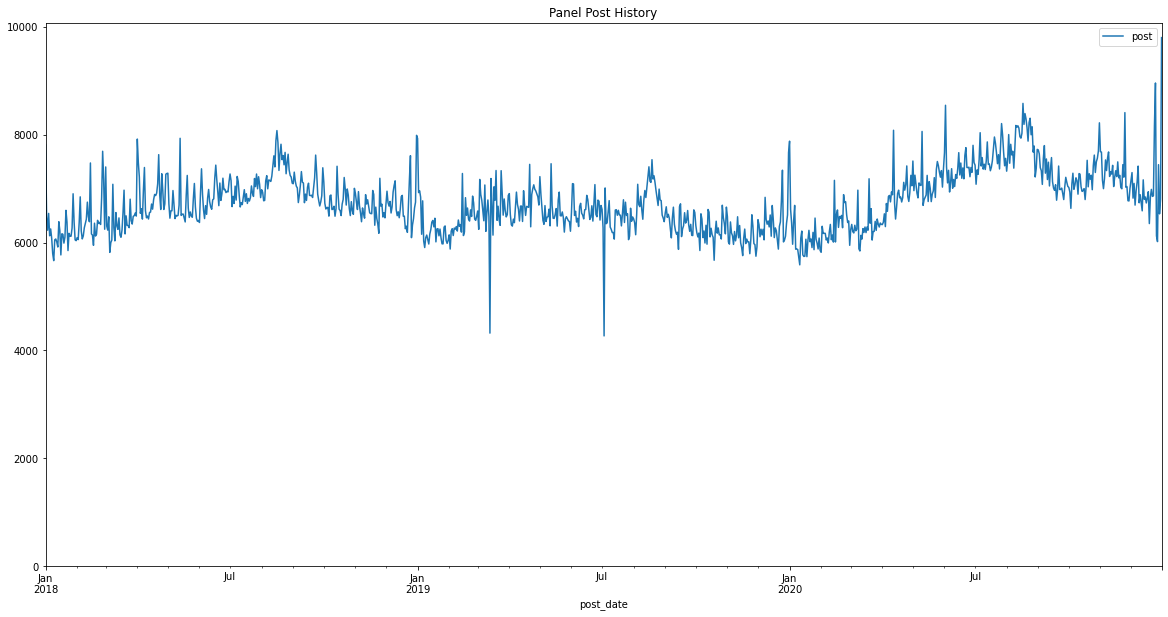

In [ ]:
df_post_history.plot(kind = 'line', ylim = (0,None), figsize = (20,10), title = 'Panel Post History')

In [ ]:
# df_post_history

## REFINE ITALIAN PANEL

In [ ]:
def remap_cities(x):
  if isinstance(x,str):
    if 'milan' in x.lower():
      return 'Milan'
    elif 'rome' in x.lower():
      return 'Other'
    else:
      return 'Other'

In [ ]:
df_italy = df_raw.loc[df_raw.mode_country == 'IT',:].copy()


In [ ]:
df_italy = df_italy[df_italy.texture_confidence>=0.50]

df_italy['mode_city_remapped'] = df_italy['mode_city'].apply(lambda x: remap_cities(x))


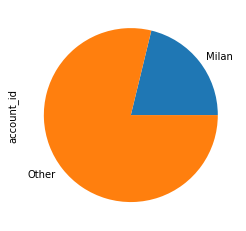

In [ ]:
df_italy.groupby('mode_city_remapped')['account_id'].count().plot(kind = 'pie')

In [ ]:
df_italy['post_month'] = df_italy['post_date']


In [ ]:
df_italy = df_italy.loc[(df_italy.post_month <= pd.Timestamp(2020,12,31)),:]
# df_italy = df_italy.loc[df_italy.min_post_date <= pd.Timestamp(2018,3,1),:]
# df_italy = df_italy.loc[df_italy.max_post_date >= pd.Timestamp(2020,9,1),:]


In [ ]:
df_italy.loc[:,'post_month'] = df_italy['post_month'].dt.strftime('%Y-%m-%d')
df_italy.loc[:,'min_post_date'] = df_italy['min_post_date'].dt.strftime('%Y-%m-%d')
df_italy.loc[:,'max_post_date'] = df_italy['max_post_date'].dt.strftime('%Y-%m-%d')

In [ ]:
# df_italy.loc[:,'post_month'] = df_italy['post_month'].dt.weekofyear
# df_italy.loc[:,'min_post_date'] = df_italy['min_post_date'].dt.weekofyear
# df_italy.loc[:,'max_post_date'] = df_italy['max_post_date'].dt.weekofyear

In [ ]:
df_italy.head()

,account_id,mode_country,mode_city,num_followers,min_post_date,max_post_date,post_date,num_comments,num_likes,post,image,object,apparel_category,apaprel_confidence,texture_category,texture_confidence,texture_name,num_followers_binned,mode_city_remapped,post_month
0,261881357,IT,"Parma, Italy",44910,2018-01-01,2021-01-17,2018-12-25,193.0,934.0,Br0lwWGFkSt,0,1,8,0.918670,11,0.964802,Paisley,2000,Other,2018-12-25
1,1638487260,IT,Alberobello,1172,2018-01-01,2020-08-26,2019-07-04,2.0,202.0,Bzfo-i5I--L,0,2,8,0.882653,10,0.963061,Snakeskin,0,Other,2019-07-04
2,8052012344,IT,Castellammare di Stabia,1940,2018-06-20,2021-01-18,2020-11-04,NaN,41.0,CHKOHPFAnTP,0,0,8,0.928235,15,0.825997,Gingham,0,Other,2020-11-04
3,5374559506,IT,"Rome, Italy",57041,2018-01-02,2021-01-17,2020-05-08,NaN,45.0,B_7M663qXwj,0,0,8,0.944112,15,0.968815,Gingham,2000,Other,2020-05-08
4,16913648,IT,"Milan, Italy",467919,2018-01-01,2021-01-18,2019-11-18,147.0,9517.0,B5Aoyv2ISlV,0,4,8,0.754498,29,0.733318,Peacock,2000,Milan,2019-11-18


In [ ]:
# sorted(df_italy.post_month.unique())

## ANALYSE TOPS TRENDS

In [ ]:
df_tops = df_italy.loc[df_italy.apparel_category.isin([8]),:].copy()


In [ ]:
df_tops.loc[:,'post_date'] = pd.to_datetime(df_tops['post_date']).dt.strftime('%Y-%m-%d')

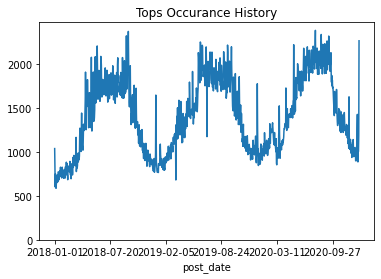

In [ ]:
df_tops.groupby(['post_date'])['post'].count().plot(kind = 'line', ylim = (0,None), title = 'Tops Occurance History')

In [ ]:
df_tops_history = df_tops.groupby(['mode_city_remapped', 'post_date'])['post'].count().unstack(0)
df_tops_history.head()



mode_city_remapped,Milan,Other
post_date,,
2018-01-01,209,832
2018-01-02,150,620
2018-01-03,144,459
2018-01-04,158,595
2018-01-05,143,457


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e4068a400>,
      dtype=object)

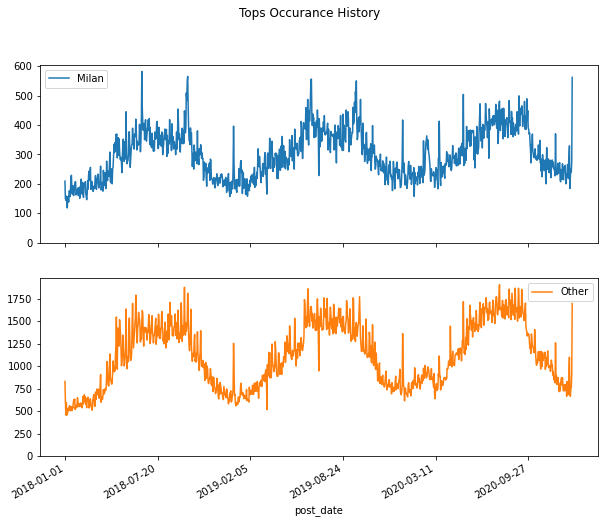

In [ ]:
df_tops_history.plot(kind = 'line',
                  figsize = (10,8),
                  subplots = True,
                  ylim = (0,None),
                  title = 'Tops Occurance History')

In [ ]:
# tops_history_psd = signal.periodogram(df_tops_history.values, fs = 365, axis = 0)
# df_tops_history_psd = pd.DataFrame(tops_history_psd[1], index = tops_history_psd[0], columns=df_tops_history.columns)


In [ ]:
# df_tops_history_psd.plot(kind = 'line',
#                          figsize = (10,8),
#                          subplots = True,
#                          ylim = (0,None),
#                          xlabel = 'Frequency (per year)',
#                          title = 'PSD of post history'
#                          )

## TEXTURE  VISIBILITY

In [ ]:
df_tops['total_engagements'] = df_tops['num_likes'] + df_tops['num_comments']

In [ ]:
df_tops.head(5)

,account_id,mode_country,mode_city,num_followers,min_post_date,max_post_date,post_date,num_comments,num_likes,post,image,object,apparel_category,apaprel_confidence,texture_category,texture_confidence,texture_name,num_followers_binned,mode_city_remapped,post_month,total_engagements
0,261881357,IT,"Parma, Italy",44910,2018-01-01,2021-01-17,2018-12-25,193.0,934.0,Br0lwWGFkSt,0,1,8,0.918670,11,0.964802,Paisley,2000,Other,2018-12-25,1127.0
1,1638487260,IT,Alberobello,1172,2018-01-01,2020-08-26,2019-07-04,2.0,202.0,Bzfo-i5I--L,0,2,8,0.882653,10,0.963061,Snakeskin,0,Other,2019-07-04,204.0
2,8052012344,IT,Castellammare di Stabia,1940,2018-06-20,2021-01-18,2020-11-04,NaN,41.0,CHKOHPFAnTP,0,0,8,0.928235,15,0.825997,Gingham,0,Other,2020-11-04,NaN
3,5374559506,IT,"Rome, Italy",57041,2018-01-02,2021-01-17,2020-05-08,NaN,45.0,B_7M663qXwj,0,0,8,0.944112,15,0.968815,Gingham,2000,Other,2020-05-08,NaN
4,16913648,IT,"Milan, Italy",467919,2018-01-01,2021-01-18,2019-11-18,147.0,9517.0,B5Aoyv2ISlV,0,4,8,0.754498,29,0.733318,Peacock,2000,Milan,2019-11-18,9664.0


In [ ]:
df_texture_history = df_tops.groupby(['texture_name', 'post_date']).agg({'total_engagements': 'sum', 'object': 'count'})

In [ ]:
df_texture_history.head()

total_engagements  object
texture_name post_date                            
Argyle       2018-01-01                0.0       1
             2018-01-05                0.0       1
             2018-01-07               60.0       1
             2018-01-08                0.0       1
             2018-01-12                0.0       1

In [ ]:
# df_texture_history = df_texture_history.unstack(level=0)
df_texture_history = df_texture_history.loc[:,['total_engagements', 'object']]

In [ ]:
df_texture_history = df_texture_history.fillna(0)

In [ ]:
df_texture_history.head()

total_engagements  object
texture_name post_date                            
Argyle       2018-01-01                0.0       1
             2018-01-05                0.0       1
             2018-01-07               60.0       1
             2018-01-08                0.0       1
             2018-01-12                0.0       1

In [ ]:
CATEGORIES = ['Plain', 'Cheetah', 'Graphic', 'Tiedye', 'Gingham', 'Checkerboard']

In [ ]:
# df_texture_history['All Cities'] = df_texture_history.Milan + df_texture_history.Other

In [ ]:
df_texture_history.head()

total_engagements  object
texture_name post_date                            
Argyle       2018-01-01                0.0       1
             2018-01-05                0.0       1
             2018-01-07               60.0       1
             2018-01-08                0.0       1
             2018-01-12                0.0       1

## ANALYSE TEXTURE CATEGORY TRENDS

In [ ]:
df_texture_history_all = df_texture_history.copy()

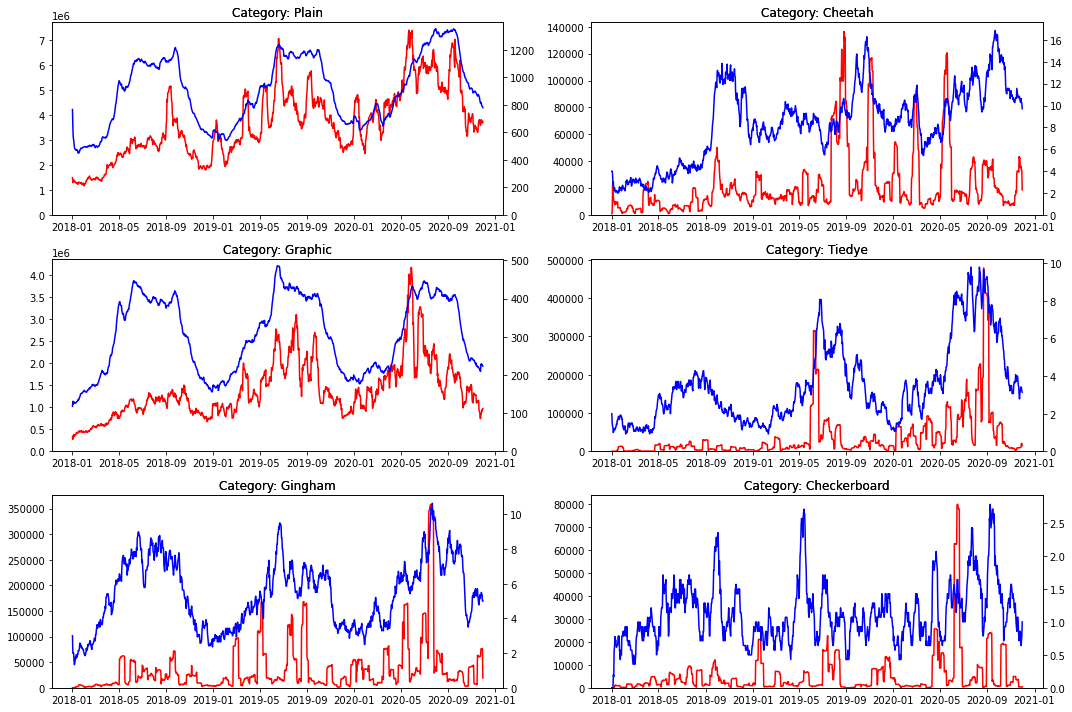

In [ ]:
fig, axarr = plt.subplots(math.ceil(len(CATEGORIES)/2),2, figsize = (15,10))
axs = axarr.ravel()
for idx, category in enumerate(CATEGORIES):
  df_temp = df_texture_history_all.loc[category]
  df_temp.index = pd.to_datetime(df_temp.index)
  df_temp = df_temp.asfreq('D')
  df_temp = df_temp.reindex(pd.date_range('2018-01-01', '2020-11-30'))
  df_temp = df_temp.fillna(0)

  df_temp = df_temp.rolling(14, min_periods=1).mean()

  axs[idx].plot(df_temp['total_engagements'], '-r',label = 'total_engagements')

  ax_ = axs[idx].twinx()
  ax_.plot(df_temp['object'], '-b', label = 'object')

  # df_temp.plot(kind = 'line', ax = axs[idx])
  axs[idx].set_title(f'Category: {category}')
  axs[idx].set_ylim((0,None))

  ax_.set_title(f'Category: {category}')
  ax_.set_ylim((0,None))

fig.tight_layout()
fig.savefig('selected_trends.png')

## ANALYSE TEXTURE

In [ ]:
## Texture map to high level categories (focused on forecasting need) and group by week

# Defining the dict of textures to be selected, remaining grouped as other
def def_value(): 
    return "Other"
text_dict = defaultdict(def_value) 
text_dict['Plain'] = 'Plain'
text_dict['Graphic'] = 'Graphic'
text_dict['Tiedye'] = 'Tiedye'
text_dict['Zebra'] = 'Zebra'
text_dict['Animal'] = 'Animal'

df_texture = df_tops.copy()
df_texture['texture_name'] = df_texture['texture_name'].map(text_dict)

In [ ]:
# Group by date and texture

df_texture = df_texture.groupby(['post_date','texture_name']).agg({'object': 'count', 'total_engagements': 'sum'})
df_texture = df_texture.reset_index().set_index('post_date')
df_texture.index = pd.to_datetime(df_texture.index)

In [ ]:
## Convert date index to date time and group by week

# Loop through each texture to align date
df_text_temp = pd.DataFrame()
for i in df_texture['texture_name'].unique().tolist():
  df_temp = df_texture[df_texture['texture_name'] == i]
  df_temp = df_temp.asfreq('d') # Upsample where data is missing
  df_temp = df_temp.reindex(pd.date_range('2018-01-01', '2020-12-31')) # Extend range of upsampling where data is missing
  df_temp = df_temp.fillna(0) # Fill upsampled with 0
  df_temp['texture_name'] = i # Fill upsampled with correct texture name
  df_text_temp = df_text_temp.append(df_temp) # Append to new dict

df_text_temp.index.name = 'post_date' # Align index names
df_text_temp = df_text_temp.reset_index().groupby([pd.Grouper(key='post_date', freq='W-MON',label='right'),'texture_name']).agg({'object': 'sum', 'total_engagements': 'sum'})
df_texture = df_text_temp.reset_index().set_index('post_date')

df_texture

,texture_name,object,total_engagements
post_date,,,
2018-01-01,Graphic,118.0,331133.0
2018-01-01,Other,155.0,187156.0
2018-01-01,Plain,766.0,1496764.0
2018-01-01,Tiedye,2.0,275.0
2018-01-01,Zebra,0.0,0.0
...,...,...,...
2021-01-04,Graphic,759.0,3522775.0
2021-01-04,Other,625.0,6576048.0
2021-01-04,Plain,3070.0,24003027.0


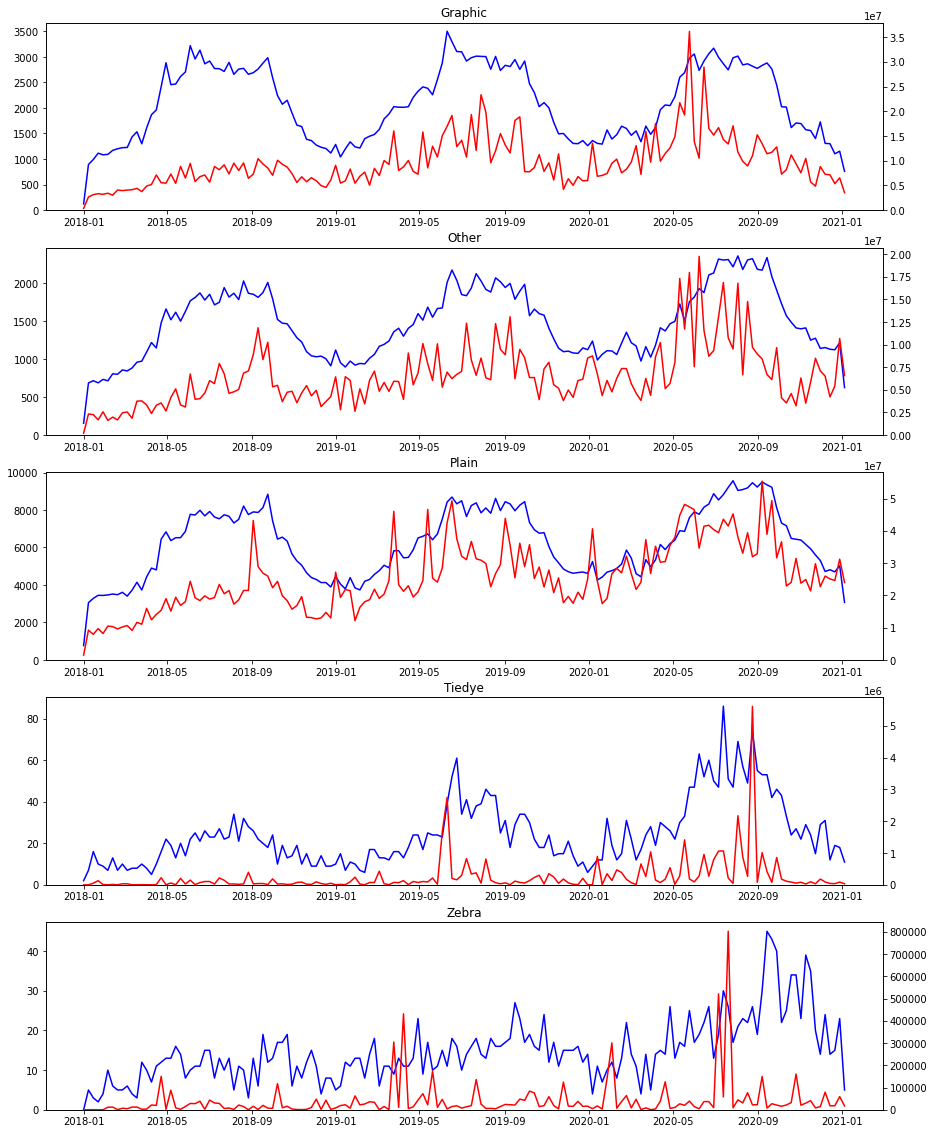

In [ ]:
## Chart showing object and egnagement history for each texture category

fig, ax = plt.subplots(len(df_texture['texture_name'].unique().tolist()), 1, figsize = (15,20))
for idx, i in enumerate(df_texture['texture_name'].unique().tolist()):
  ax = plt.subplot(len(df_texture['texture_name'].unique().tolist()), 1, idx+1)
  ax.title.set_text(i)
  ax_ = ax.twinx()
  ax.plot(df_texture[df_texture['texture_name'] == i]['object'], '-b', label = 'object')
  ax_.plot(df_texture[df_texture['texture_name'] == i]['total_engagements'], '-r', label = 'total_engagements')

  ax.set_ylim((0,None))
  ax_.set_ylim((0,None))

(0.0, 19515.92051282051)

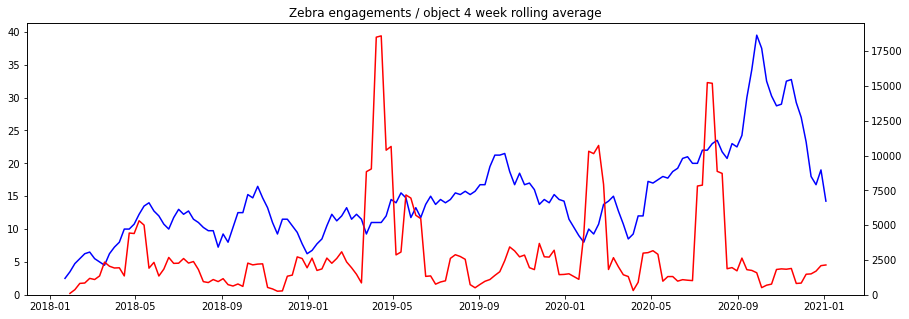

In [ ]:
## Chart showing object and egnagement / object history for each texture category

CHOSEN_TEXTURE = 'Zebra'
ROLLING_PERIOD = 4

df_text_rolling = df_texture[df_texture['texture_name'] == CHOSEN_TEXTURE].copy(deep=True)
df_text_rolling['engagements_per_object'] = df_text_rolling['total_engagements'] / df_text_rolling['object']
df_text_rolling = df_text_rolling.rolling(ROLLING_PERIOD).mean()

fig, ax = plt.subplots(1, 1, figsize = (15,5))

ax.title.set_text(CHOSEN_TEXTURE + ' engagements / object ' + str(ROLLING_PERIOD) + ' week rolling average')
ax_ = ax.twinx()
ax.plot(df_text_rolling['object'], '-b', label = 'object')
ax_.plot(df_text_rolling['engagements_per_object'], '-r', label = 'engagements per object')

ax.set_ylim((0,None))
ax_.set_ylim((0,None))

## FORECASTING

In [ ]:
df_texture_fcst = df_texture.copy(deep=True)

In [ ]:
## Forecasting control variables
REMAP_WEEK = True
TEST_MONTH = 8
NUM_DAYS_LAG = 365

In [ ]:
## Calculate share columns
df_texture_fcst = df_texture_fcst.join(df_texture_fcst.groupby('post_date').agg({'object': 'sum', 'total_engagements': 'sum'}),rsuffix='_total')
df_texture_fcst['object_share'] = df_texture_fcst['object'] / df_texture_fcst['object_total']
df_texture_fcst['total_engagements_share'] = df_texture_fcst['total_engagements'] / df_texture_fcst['total_engagements_total']

,texture_name,object,total_engagements,object_total,total_engagements_total,object_share,total_engagements_share
post_date,,,,,,,
2018-01-01,Graphic,118.0,331133.0,1041.0,2015328.0,0.113353,0.164307
2018-01-01,Other,155.0,187156.0,1041.0,2015328.0,0.148895,0.092866
2018-01-01,Plain,766.0,1496764.0,1041.0,2015328.0,0.735831,0.742690
2018-01-01,Tiedye,2.0,275.0,1041.0,2015328.0,0.001921,0.000136
2018-01-08,Graphic,892.0,2636846.0,4646.0,14196023.0,0.191993,0.185745
...,...,...,...,...,...,...,...
2020-12-28,Tiedye,18.0,88240.0,7432.0,48565863.0,0.002422,0.001817
2021-01-04,Graphic,759.0,3522775.0,4470.0,34154881.0,0.169799,0.103141
2021-01-04,Other,630.0,6593585.0,4470.0,34154881.0,0.140940,0.193050


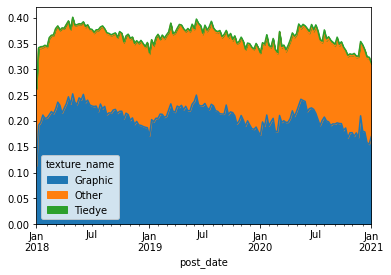

In [ ]:
df_texture_fcst[df_texture_fcst['texture_name'] != 'Plain'].set_index(
    [df_texture_fcst[df_texture_fcst['texture_name'] != 'Plain'].index,'texture_name'])['object_share'].unstack().plot.area()

In [ ]:
df_y = pd.DataFrame(df_chosen_texture_history['object'].copy(deep = True))
# df_regressor = pd.DataFrame(df_chosen_texture_history['total_engagements'].copy(deep = True))


In [ ]:
if not REMAP_WEEK:
  df_y = df_y.rolling(14, min_periods=1).mean()
  # df_regressor = df_regressor.rolling(14, min_periods=1).mean()

df_regressor = pd.DataFrame(df_y['object'].diff(1))
df_regressor = df_regressor.fillna(0)

In [ ]:
df_y = df_y.rename({'object': 'y'}, axis = 1)
# df_regressor = df_regressor.rename({'total_engagements': 'regressor'}, axis = 1)
df_regressor = df_regressor.rename({'object': 'regressor'}, axis = 1)

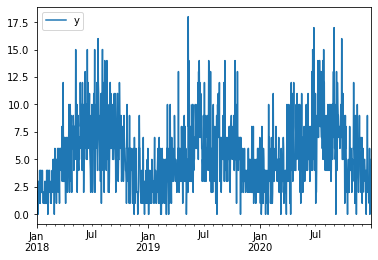

In [ ]:
df_y.plot()

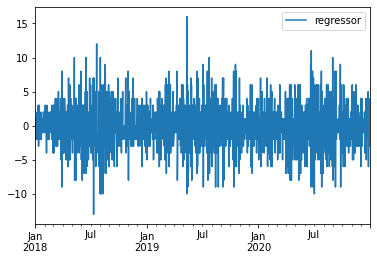

In [ ]:
df_regressor.plot()

### PREPARE INPUTS AND REGRESSORS

In [ ]:
df_y_train = df_y[(df_y.index >= pd.Timestamp(2018,1,1) + pd.DateOffset(days=NUM_DAYS_LAG)) & (df_y.index <= pd.Timestamp(2020,TEST_MONTH,30))]

df_y_test = df_y[(df_y.index > pd.Timestamp(2020,TEST_MONTH,30)) & (df_y.index <= pd.Timestamp(2020,12,31))]

In [ ]:
df_regressor_train = df_regressor[(df_regressor.index >= pd.Timestamp(2018,1,1))
   & (df_regressor.index <= pd.Timestamp(2020,TEST_MONTH,30) - pd.DateOffset(days=NUM_DAYS_LAG))]
   
df_regressor_test = df_regressor[(df_regressor.index > pd.Timestamp(2020,TEST_MONTH,30) - pd.DateOffset(days=NUM_DAYS_LAG))
   & (df_regressor.index <= pd.Timestamp(2020,12,31) - pd.DateOffset(days=NUM_DAYS_LAG))]

In [ ]:
df_regressor_remainder = df_regressor[(df_regressor.index > pd.Timestamp(2020,12,31) - pd.DateOffset(days=NUM_DAYS_LAG))]

In [ ]:
print(len(df_y_train))
print(len(df_regressor_train))


608
608


In [ ]:
print(len(df_y_test))
print(len(df_regressor_test))


123
123


In [ ]:
# re-index the regressors
df_regressor_train.index = df_y_train.index
df_regressor_test.index = df_y_test.index

In [ ]:
df_training = pd.concat([df_y_train, df_regressor_train], axis = 1)
df_training = df_training.reset_index().rename({'index': 'ds'}, axis = 1)

df_testing = pd.concat([df_y_test, df_regressor_test], axis = 1)
df_testing = df_testing.reset_index().rename({'index': 'ds'}, axis = 1)


In [ ]:
### CONVERT TRAINING TO WEEK OF YEAR
if REMAP_WEEK:
  df_training.loc[:,'ds'] = pd.to_datetime(df_training.ds.apply(lambda x: date_converter(x)))
df_training = df_training.groupby('ds').agg({'y': 'sum', 'regressor': 'sum'}).reset_index()

In [ ]:
df_training.head()

,ds,y,regressor
0,2019-01-01,16.0,-3.0
1,2019-01-07,19.0,1.0
2,2019-01-14,18.0,3.0
3,2019-01-21,24.0,-3.0
4,2019-01-28,11.0,0.0


In [ ]:
df_training.tail()

,ds,y,regressor
95,2020-08-01,40.0,-1.0
96,2020-08-07,46.0,-8.0
97,2020-08-14,50.0,8.0
98,2020-08-21,51.0,-6.0
99,2020-08-28,30.0,5.0


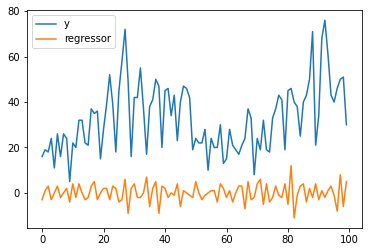

In [ ]:
df_training[['y', 'regressor']].plot(kind = 'line')

In [ ]:
### CONVERT TESTING TO WEEK OF YEAR
if REMAP_WEEK:
  df_testing.loc[:,'ds'] = pd.to_datetime(df_testing.ds.apply(lambda x: date_converter(x)))
df_testing = df_testing.groupby('ds').agg({'y': 'sum', 'regressor': 'sum'}).reset_index()

In [ ]:
df_testing.head()

,ds,y,regressor
0,2020-08-28,17.0,-1.0
1,2020-09-01,36.0,-3.0
2,2020-09-07,57.0,0.0
3,2020-09-14,52.0,4.0
4,2020-09-21,60.0,-1.0


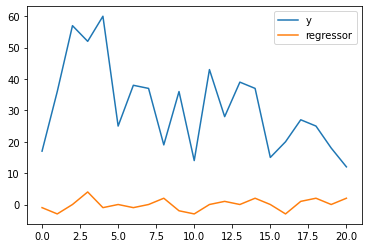

In [ ]:
df_testing[['y', 'regressor']].plot(kind = 'line')

In [ ]:
df_testing.tail()

,ds,y,regressor
16,2020-12-01,20.0,-3.0
17,2020-12-07,27.0,1.0
18,2020-12-14,25.0,2.0
19,2020-12-21,18.0,0.0
20,2020-12-28,12.0,2.0


In [ ]:
df_regressor_remainder_full = df_regressor_remainder.reset_index()
df_regressor_remainder_full = df_regressor_remainder_full.rename({'index': 'ds'}, axis = 1)
df_regressor_remainder_full['ds'] = df_regressor_remainder_full['ds'] + pd.DateOffset(NUM_DAYS_LAG)


In [ ]:
### CONVERT FORECASTING REGRESSORS TO WEEK OF YEAR
if REMAP_WEEK:
  df_regressor_remainder_full.loc[:,'ds'] = pd.to_datetime(df_regressor_remainder_full.ds.apply(lambda x: date_converter(x)))
df_regressor_remainder_full = df_regressor_remainder_full.groupby('ds').agg({'regressor': 'sum'}).reset_index()

In [ ]:
df_regressor_remainder_full.head()

,ds,regressor
0,2021-01-01,-6.0
1,2021-01-07,4.0
2,2021-01-14,-1.0
3,2021-01-21,-4.0
4,2021-01-28,3.0


In [ ]:
df_regressor_remainder_full.tail()

,ds,regressor
55,2021-12-01,-4.0
56,2021-12-07,1.0
57,2021-12-14,-2.0
58,2021-12-21,2.0
59,2021-12-28,1.0


### FB Prophet

In [ ]:
from fbprophet import Prophet


In [ ]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)
m.add_regressor('regressor',standardize=False)


In [ ]:
if REMAP_WEEK:
  idx = df_training
  df_training['y'] = df_training['y'].rolling(window = 2, min_periods=1).mean()
  df_testing['y'] = df_testing['y'].rolling(window = 2, min_periods=1).mean()


  # df_training['regressor'] = df_training['regressor'].rolling(window = 4, min_periods=1).mean()
  # df_testing['regressor'] = df_testing['regressor'].rolling(window = 4, min_periods=1).mean()
  # df_testing['regressor'] = df_testing['regressor'].rolling(window = 4, min_periods=1).mean()

In [ ]:
df_regressor_full = pd.concat([df_training[['ds','regressor']], df_testing[['ds','regressor']]], axis = 0).reset_index(drop = True)

In [ ]:
m.fit(df_training)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = df_regressor_full.copy()

In [ ]:
future.head()

,ds,regressor
0,2019-01-01,-3.0
1,2019-01-07,1.0
2,2019-01-14,3.0
3,2019-01-21,-3.0
4,2019-01-28,0.0


In [ ]:
future.tail()

,ds,regressor
116,2020-12-01,-3.0
117,2020-12-07,1.0
118,2020-12-14,2.0
119,2020-12-21,0.0
120,2020-12-28,2.0


In [ ]:
print(len(future))

121


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2020-12-01,28.105743,15.045783,42.074634
117,2020-12-07,22.195786,8.432048,36.691754
118,2020-12-14,21.867238,8.658787,36.161200
119,2020-12-21,20.819410,6.512154,34.298443
120,2020-12-28,19.585657,5.270847,33.395697


### Visualise Validation

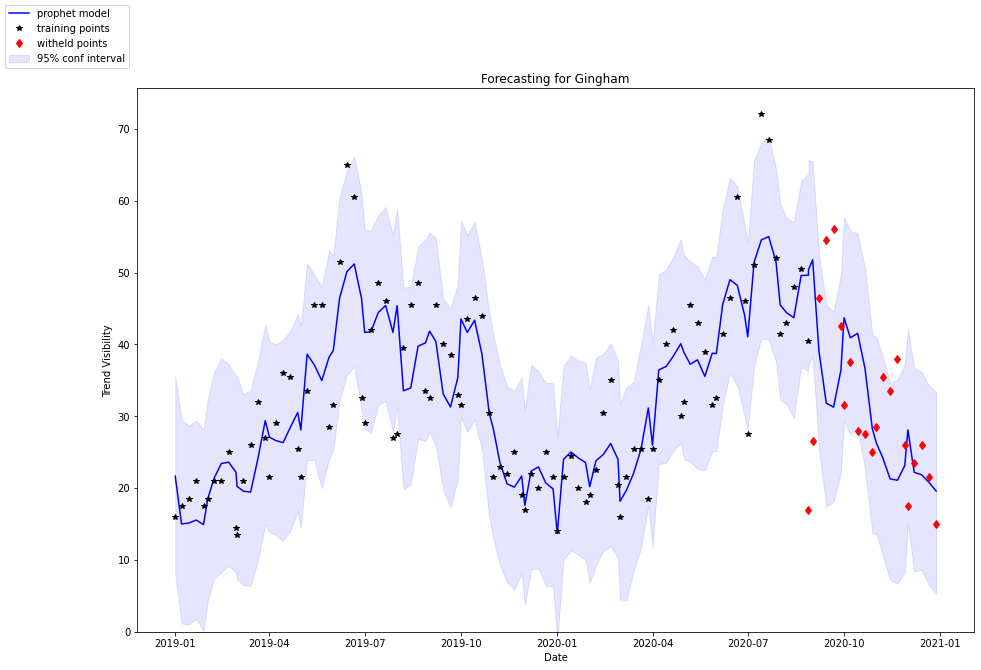

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15, 10))
ax.plot(forecast.ds, forecast.yhat, '-b', label = 'prophet model')
# ax.plot(df_testing.ds, forecast_hwes.values, '-g', label = 'exponential smoothing model')
ax.plot(forecast.ds[:len(df_training.y)], df_training.y, '*k', label = 'training points')
ax.plot(forecast.ds[-len(df_testing.y):], df_testing.y,'dr', label = 'witheld points')
ax.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, color='b', alpha=.1, label = '95% conf interval')

ax.set_ylim((0,None))

ax.set_xlabel('Date')
ax.set_ylabel('Trend Visibility')
ax.set_title(f'Forecasting for {CHOSEN_TEXTURE}')
fig.legend(loc = 'upper left')

fig.savefig(f'prophet_{CHOSEN_TEXTURE.lower()}.jpg')


### FORECASTING

In [ ]:
future_full = pd.concat([future, df_regressor_remainder_full]).reset_index(drop = True)

In [ ]:
future_full.head()

,ds,regressor
0,2019-01-01,-3.0
1,2019-01-07,1.0
2,2019-01-14,3.0
3,2019-01-21,-3.0
4,2019-01-28,0.0


In [ ]:
future_full.tail()

,ds,regressor
176,2021-12-01,-4.0
177,2021-12-07,1.0
178,2021-12-14,-2.0
179,2021-12-21,2.0
180,2021-12-28,1.0


In [ ]:
forecast_long = m.predict(future_full)
forecast_long[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2021-12-01,20.310550,7.134471,34.037676
177,2021-12-07,31.183277,16.673844,45.063752
178,2021-12-14,31.410062,18.518302,45.693305
179,2021-12-21,29.630854,15.484420,43.176826
180,2021-12-28,28.738281,14.950051,42.915983


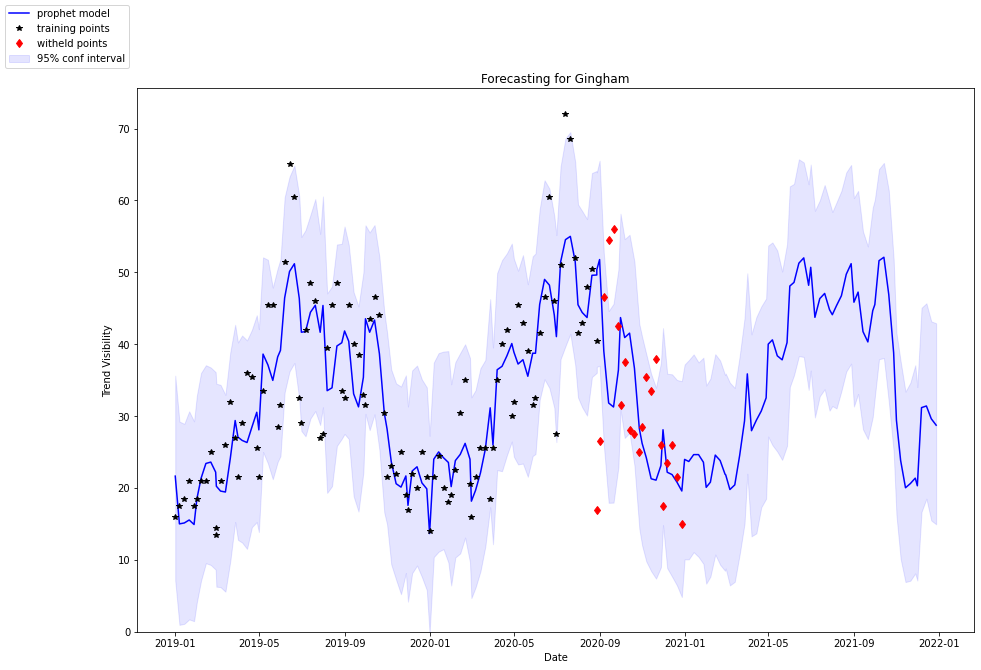

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15, 10))
ax.plot(forecast_long.ds, forecast_long.yhat, '-b', label = 'prophet model')
# ax.plot(df_testing.ds, forecast_hwes.values, '-g', label = 'exponential smoothing model')
ax.plot(forecast.ds[:len(df_training.y)], df_training.y, '*k', label = 'training points')
ax.plot(forecast.ds[-len(df_testing.y):], df_testing.y,'dr', label = 'witheld points')
ax.fill_between(forecast_long.ds, forecast_long.yhat_lower, forecast_long.yhat_upper, color='b', alpha=.1, label = '95% conf interval')

ax.set_ylim((0,None))

ax.set_xlabel('Date')
ax.set_ylabel('Trend Visibility')
ax.set_title(f'Forecasting for {CHOSEN_TEXTURE}')
fig.legend(loc = 'upper left')

fig.savefig(f'long_forecast_{CHOSEN_TEXTURE.lower()}.jpg')


## VISUALISE TEXTURES

In [ ]:
df_tops.texture_name.unique()

array(['Paisley', 'Snakeskin', 'Gingham', 'Peacock', 'Checkerboard',
       'Zebra', 'Star', 'Tiedye', 'Houndstooth', 'Leaf', 'Heart',
       'Chevron-Zigzag', 'Fair isle', 'Toile de jouy', 'Chain-Ornate',
       'Camouflage', 'Fire', 'Fruit', 'Argyle', 'Butterfly', 'Tiger',
       'Giraffe', 'Plain', 'Cheetah', 'Floral', 'Stripe', 'Plaid',
       'Geometric', 'Ditsy', 'Colourblock', 'Dotted', 'Graphic'],
      dtype=object)

In [ ]:
df_text_test = df_tops[df_tops['texture_name'] == 'Gingham'].copy()

# Fill NA with "no_detections" to use in analysis, sets to 0 confidence and gets taken out in next step
# df_text_test = df_text_test.fillna(value={'graphics_category': -1, 'graphics_name': 'no_detections', 'graphics_confidence': 0})

# Set confidence threshold
df_text_test = df_text_test[df_text_test['texture_confidence'] >= 0.70] #TODO MO to recommend confidence level

# Show only graphic_size_large
#df_text_test = df_text_test[df_text_test['graphics_name'].isin(['graphic_size_large','graphic_size_medium'])]

len(df_text_test)

4391

In [ ]:
# Display random 50 images
urls = 'https://storage.cloud.google.com/instagram_images_graphics_unblurred/' + df_text_test['post'] + '_' + df_text_test['image'].astype(str) + '.jpg'
urls = urls.sample(n = 10).tolist() 

gallery(urls, row_height='250px')